# Week 10 - Dimensionality Reduction

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">
In this lab, you'll get a chance to experiment with library implementations of the dimensionality reduction techniques discussed in this week's lectures.

We will be performing dimensionality reduction on gene-expression data from different tissues of fruit flies.
</div>

## Setup

### Installation notes

To run this notebook you will need to install several packages. These can be installed via pip.
```bash
pip install --upgrade pip
pip install pandas scikit-learn umap-learn matplotlib seaborn ipykernel
```

> **Note** <br>
> Ensure pip is updated to 23.2.1 or later, otherwise you may experience errors. 

In [1]:
import re
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap  # You can ignore the warnings about Numba
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Display 2 decimal places for floats
pd.set_option('display.max_rows', 150)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Set default figure size to a larger size
plt.rcParams['figure.figsize'] = [8, 8]

/Users/unlock/Projects/Tutor/Github/COMP90014_2025/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

We will be using microarray gene-expression data from [FlyAtlas](http://flyatlas.org/atlas.cgi), part of [NCBI's Gene Expression Omnibus](https://www.ncbi.nlm.nih.gov/geo/). 

The dataset includes gene expression information from a variety of cell types. The file is present relative to this notebook at <small>`./data/flydata.txt.gz`</small>. 

Columns
- Each column represents a sample. 
- These 136 columns represent 4 replicates each from 34 different tissue types / developmental stages.

Rows
- Each row represents a microarray probe. 
- These 18952 probes can be mapped to gene names but we will skip that for today. 

Run the following cell to load the data. 

> Note 
> - <small>`gzip`</small> is used to open the file as it is gzip compressed. 
> - <small>`comment='!'`</small> tells Pandas to treat any lines starting with '!' as comments. <br>
  This is useful because the flydata.txt file has header lines providing documentation.
> - <small>`index_col=0`</small> tells Pandas to use the first column as index. 
> - <small>`sep='\t'`</small> tells Pandas that the flydata.txt file is tab-separated. 
> - The original sample names (columns) are uninformative, so we pull their labels from the header comments and reassign. 
> 
> <br>

In [2]:
# read expression data from file
with gzip.open('./data/flydata.txt.gz', 'rt') as fp:
    expression = pd.read_csv(fp, sep='\t', comment='!', index_col=0)
    
# search the header lines for sample descriptions so columns can be relabelled. 
with gzip.open('./data/flydata.txt.gz', 'rt') as fp:
    line = fp.readline()
    while line:
        if line.startswith("!Sample_title"):
            header = [x.strip('"') for x in line.split("\t")[1:]]
            expression.columns = header
            break
        line = fp.readline()

expression

,Adult Hind Gut biological rep1,Adult Hind Gut biological rep2,Adult Hind Gut biological rep3,Adult Hind Gut biological rep4,Adult Mid Gut biological rep1,Adult Mid Gut biological rep2,Adult Mid Gut biological rep3,Adult Mid Gut biological rep4,Adult Accessory gland biological rep1,Adult Accessory gland biological rep2,...,Adult Thoracic Muscle biological rep3,Adult Thoracic Muscle biological rep4,Adult Wings biological rep1,Adult Wings biological rep2,Adult Wings biological rep3,Adult Wings biological rep4,Adult Female Spermatheca Mated (REDONE) biological rep1,Adult Female Spermatheca Mated (REDONE) biological rep2,Adult Female Spermatheca Mated (REDONE) biological rep3,"Adult Female Spermatheca Mated (REDONE) biological rep4""\n"
ID_REF,,,,,,,,,,,,,,,,,,,,,
1616608_a_at,"1,092.98",954.80,"1,111.61","1,052.77","1,253.53","1,059.88","1,173.37","1,193.86","1,155.71","1,036.53",...,"5,887.97","1,874.55",804.52,692.33,983.80,813.85,"2,557.62","9,660.47","2,034.63","2,236.47"
1622892_s_at,59.96,73.31,70.48,86.44,45.01,62.83,59.48,45.96,117.23,120.68,...,114.69,65.35,75.92,90.98,73.67,66.17,90.45,138.45,56.28,65.05
1622893_at,277.00,311.82,368.85,299.89,8.88,3.25,7.82,6.47,14.83,17.92,...,"1,007.28","6,599.77","2,592.33","4,450.39","2,793.96","3,488.12","6,614.50",339.25,"8,948.10","8,636.37"
1622894_at,24.49,17.08,10.82,29.35,8.98,6.90,7.23,10.91,8.15,1.31,...,16.57,155.59,35.42,41.90,39.28,37.06,114.25,10.02,165.88,156.43
1622895_at,57.28,57.80,47.56,37.91,56.25,74.29,69.27,56.65,124.73,148.08,...,25.96,95.47,56.01,66.21,71.24,65.47,88.54,56.81,44.01,74.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AFFX-ThrX-5_at,0.79,0.87,0.45,3.92,1.12,0.75,1.54,1.32,6.62,1.33,...,22.52,11.70,4.67,9.15,10.03,3.04,9.90,28.38,7.90,12.97
AFFX-ThrX-M_at,3.32,1.05,0.38,0.86,1.97,4.66,3.82,1.27,1.70,2.23,...,70.72,34.69,17.91,19.04,14.64,12.60,47.05,64.68,19.52,23.37
AFFX-TrpnX-3_at,3.59,0.36,1.05,0.40,1.15,0.91,0.35,0.51,2.28,0.62,...,2.29,2.30,1.28,1.18,0.38,1.78,0.79,0.87,4.31,4.47


### Get Cell Type Labels

The following code snippet uses regular expressions and custom functions to generate metadata using sample names. <br>
These will be used as categories for plotting and labels later.

In [3]:
def get_development(text: str) -> str:
    if 'Adult' in text:
        return 'Adult'
    elif 'Larval Wandering' in text:
        return 'Larval Wandering'
    elif 'Larval Feeding' in text:
        return 'Larval Feeding'
    elif 'S2 Cells' in text:
        return 'Passaged Cells'
    else:
        raise NotImplementedError
    
def get_tissue(row: pd.Series) -> str:
    sample_words = row['sample'].split(' ')
    develop_words = row['development'].split(' ')
    return ' '.join([x for x in sample_words if x not in develop_words])

PATTERN = r'(.+?)(( biological)? rep\d+)'
meta = pd.DataFrame()
meta['ID'] = expression.columns.to_list()
meta['sample'] = meta['ID'].apply(lambda x: re.match(PATTERN, x).group(1))
meta['sample'] = meta['sample'].apply(lambda x: x.replace('Larvae', 'Larval'))
meta['development'] = meta['sample'].apply(get_development)
meta['tissue'] = meta.apply(get_tissue, axis=1)
meta.head()

,ID,sample,development,tissue
0,Adult Hind Gut biological rep1,Adult Hind Gut,Adult,Hind Gut
1,Adult Hind Gut biological rep2,Adult Hind Gut,Adult,Hind Gut
2,Adult Hind Gut biological rep3,Adult Hind Gut,Adult,Hind Gut
3,Adult Hind Gut biological rep4,Adult Hind Gut,Adult,Hind Gut
4,Adult Mid Gut biological rep1,Adult Mid Gut,Adult,Mid Gut


### Transforming Expression Data

Before plotting the expression data, it's common practice to take the log of expression values. <br>
**Log transforming** count data is very common practise in data science, especially biology. <br>
Let's see why:


In [4]:
# Create log transformed expression values
log_expression = np.log(expression + 1)

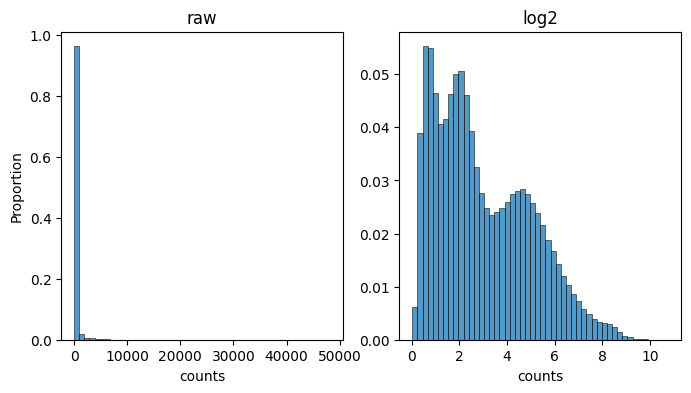

In [5]:
# Plot original transcript counts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax_raw = axes[0]
ax_log = axes[1]
sns.histplot(expression.values.flatten(), bins=50, ax=ax_raw, stat='proportion')
sns.histplot(log_expression.values.flatten(), bins=50, ax=ax_log, stat='proportion')
ax_raw.set_title('raw')
ax_raw.set_xlabel('counts')
ax_log.set_title('log2')
ax_log.set_xlabel('counts')
ax_log.set_ylabel('')
plt.show()

There are a small number of very highly expressed genes in our dataset.  Variation in these genes may have a disproportionately large effect on attempts to find structure in our data (highly expressed genes will have higher varances). By log transforming our data we can map expression values to an approximately normal distribution.  

### Plotting Expression Data

The following function will render a two-dimensional scatterplot which is coloured by the list of categories. <br>
We will use it for PCA, MDS, tSNE, UMAP, and LDA visualizations.

In [6]:
import itertools

def plot_two_dimensions(data: pd.DataFrame, meta: pd.DataFrame, label: str='tissue'):
    fig, ax = plt.subplots(figsize=(7, 6))

    # Define colors and markers to cycle through
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    markers = ['o', 's', '^', 'D', '*', 'h', '>']
    combinations = list(itertools.product(markers, colors))

    # developmental stage
    i = 0
    for group, samples in meta.groupby(label)['ID'].agg(list).to_dict().items():
        df = data.loc[samples].copy()
        ax.scatter(
            df[0], df[1], label=group, c=combinations[i][1], marker=combinations[i][0],
            s=50, alpha=0.7, edgecolors='black', linewidths=0.5
        )
        i += 1
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
    ax.set_title(label)
    plt.show()
    

### Dimensionality Reduction with PCA

The following code performs PCA on the dataset.  

Here is an intro video on PCA [StatQuest: Principal Component Analysis (PCA)](https://www.youtube.com/watch?v=FgakZw6K1QQ) if you want a refresher. 

Steps:
1. Initialise the PCA reducer class 
2. Transpose the dataframe so each row is a sample (currently they're columns)
3. Perform pca using `.fit()` to identify low-dimension mapping 
4. Transform the original data into low-dimensional space using `.transform()`
5. Plot 


high-dimensional data: 136 samples, 18952 probes.

ID_REF                          1616608_a_at  1622892_s_at  1622893_at  1622894_at  1622895_at
Adult Hind Gut biological rep1          7.00          4.11        5.63        3.24        4.07
Adult Hind Gut biological rep2          6.86          4.31        5.75        2.89        4.07
Adult Hind Gut biological rep3          7.01          4.27        5.91        2.47        3.88
Adult Hind Gut biological rep4          6.96          4.47        5.71        3.41        3.66
Adult Mid Gut biological rep1           7.13          3.83        2.29        2.30        4.05

low-dimensional data: 136 samples, 136 dimensions.

                                    0      1     2     3      4
Adult Hind Gut biological rep1  11.23 -34.89 19.75 40.20  17.02
Adult Hind Gut biological rep2  14.18 -37.33 17.80 38.12  16.58
Adult Hind Gut biological rep3  16.99 -39.53 17.27 37.20  16.41
Adult Hind Gut biological rep4  13.42 -36.55 19.97 39.29  17.59
Adult 

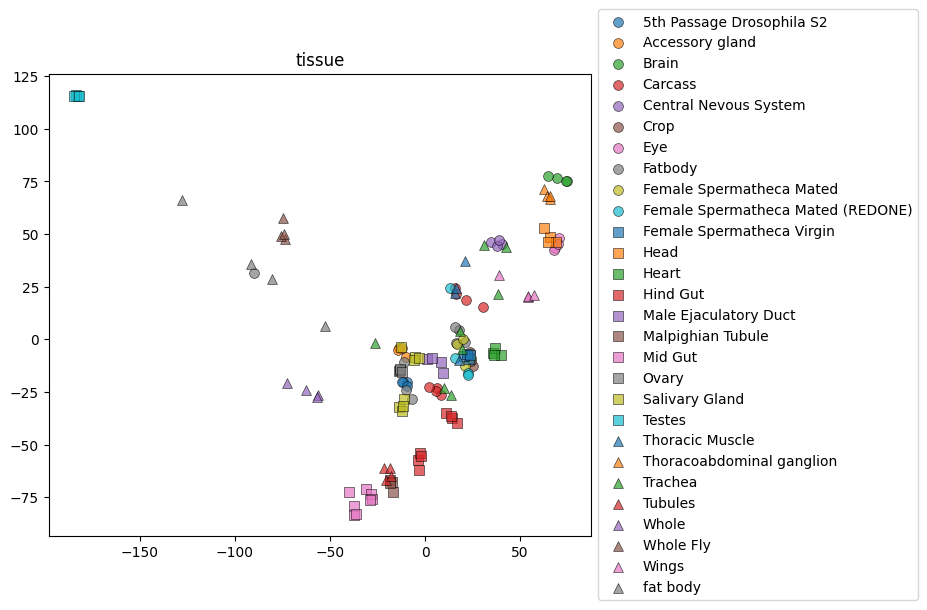

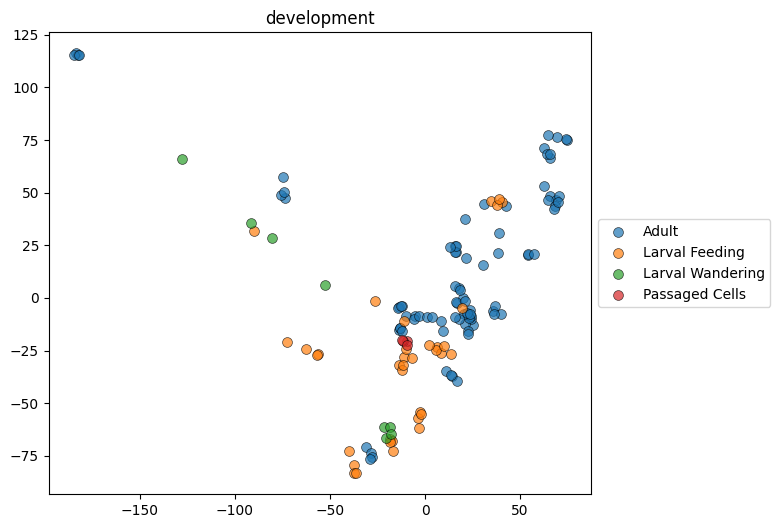

In [7]:
# 1. initialise reducer
pca = PCA()

# 2. transpose matrix so each row is a sample 
input_df = log_expression.T
print(f"high-dimensional data: {input_df.shape[0]} samples, {input_df.shape[1]} probes.\n")
print(input_df.iloc[:5, :5])

# 3. perform pca to identify low-dimension mapping
pca.fit(input_df)

# 4. transform the original data into low-dimensional space using learned mapping
result = pca.transform(input_df)

# 5. plot 
# turn the numpy nd.array into a dataframe with sample ID for plotting
result_df = pd.DataFrame(result, index=input_df.index.to_list())
print(f"\nlow-dimensional data: {result_df.shape[0]} samples, {result_df.shape[1]} dimensions.\n")
print(result_df.iloc[:5, :5])

# visualse first two dimensions 
plot_two_dimensions(result_df, meta, 'tissue')
plot_two_dimensions(result_df, meta, 'development')

In [8]:
pca.explained_variance_ratio_[0]

np.float64(0.13853165817014546)

Using these visualisations, there are a number of interesting observations we can make
- *'Malphingian tubule'* tissue samples have similar expression to general *'Tubule'* tissue (bottom middle).
- *'Brain', 'Head', 'Eye', 'Central Nervous System', and 'Thoracoabdominal Gangleon'* tissue cluster together (top right). 
- Developmental stages display separation, with some exceptions (which make biological sense).
    - *'Mid Gut'* tissue is similar in both Adults & Larval Feeding (Bottom middle)
    - *'Central Nervous System'* tissue in Larval Feeding is similar to Adult *'Brain', 'Head', 'Eye'* and *'Thoracoabdominal Gangleon'* tissue (top right)

## Fitting and Transforming

**`.fit()` then `.transform()`**

In the example above we learned the mapping and transformed the data in two steps.

This can be handy for ***supervised machine learning*** tasks where the data is split into a training and test set.  In situations where your data is high-dimensional (ie #features > #observations), you should perform feature selection or feature extraction to improve model performance. If using feature selection there is no issue, as the selected features are present in both the training and test set. On the other hand, feature extraction *learns* a mapping based on input data! In these situations you have to <small>`.fit()`</small> PCA on the training dataset only, then <small>`.transform()`</small> both the training and test sets into low-dimensional space using the same learned mapping. PCA and LDA are good choices for feature extraction as can reduce thousands of dimensions into a user-defined number (eg, 2, 5, 10 etc). 


**`.fit_transform()`**

If your task is unsupervised (ie for visualisation / clustering), you can use <small>`.fit_transform(matrix)`</small> instead which performs both steps together. 

Here is an example using PCA. 

<div style='font-size: 18px'>

```bash
reducer = PCA(n_components=2)  # PCA | MDS | TSNE | UMAP 
result = reducer.fit_transform(data)
```

</div>

In the remaining exercises we will perform dimensionality reducion using MDS, tSNE, and UMAP. 

Similar to PCA, the packages we will use all follow the <small>`.fit_transform(matrix)`</small> syntax. <br>
Each reduction technique has a different set of parameters aside from <small>`n_components`</small>. <br>
For example, you can supply a value for the <small>`perplexity`</small> parameter to TSNE. 



## Exercise 1: PCA Explained Variance

This code makes a plot of the explained variance by component, like we saw on one of the lecture slides.

[0.13853166 0.10866708 0.10150852 0.07383439 0.05613647]


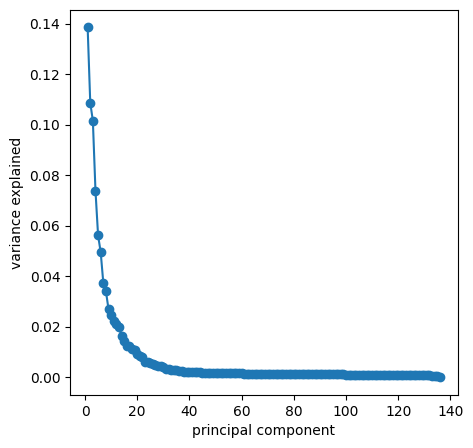

In [9]:
print(pca.explained_variance_ratio_[:5])
fig = plt.figure(figsize=(5, 5))
plt.plot([x + 1 for x in range(len(pca.explained_variance_ratio_))], pca.explained_variance_ratio_, 'o-')
plt.xlabel("principal component")
plt.ylabel("variance explained")
plt.show()

We've seen that the ammount of additional explained variance diminishes as we all more components.

How many components do you think are worth keeping for our analysis?

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">
<b>Challenge:</b> Calculate the number of components required to explain at least 90% of the variance in our data.

Generally, we take as many components as necessary to cover 90% of the sample variance. 

We will just take the cumulative sum until we have over 90% explained variance, and report how many components we needed.
    
Hint: You can find the variance explained by each component with `pca.explained_variance_ratio_`
</div>

In [ ]:
# YOUR CODE HERE
### BEGIN SOLUTION
i = 0
max_components = len(pca.explained_variance_ratio_)

explained_variance = 0
while explained_variance < 0.99 and i < max_components:
    explained_variance += pca.explained_variance_ratio_[i]
    i += 1
    
print(f'{i} components explain {round(explained_variance * 100, 2)}% of the variation in our data.')
### END SOLUTION

122 components explain 99.02% of the variation in our data.


## Exercise 2: Multidimensional Scaling (MDS)

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">
<b>Challenge:</b> Try creating an MDS plot using `MDS()`, which we imported from `sklearn.manifold`. All scikit-learn models use a consistent syntax, so the syntax is extremely similar to that for `PCA()`.

This should produce a near-identical plot to PCA as we are not changing the MDS distance metric from euclidean (default). 

Examine the documentation either online or just using `help(MDS)` in the notebook.

</div>

StatQuest intro to [MDS and PCoA](https://youtu.be/GEn-_dAyYME)

/Users/unlock/Projects/Tutor/Github/COMP90014_2025/venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


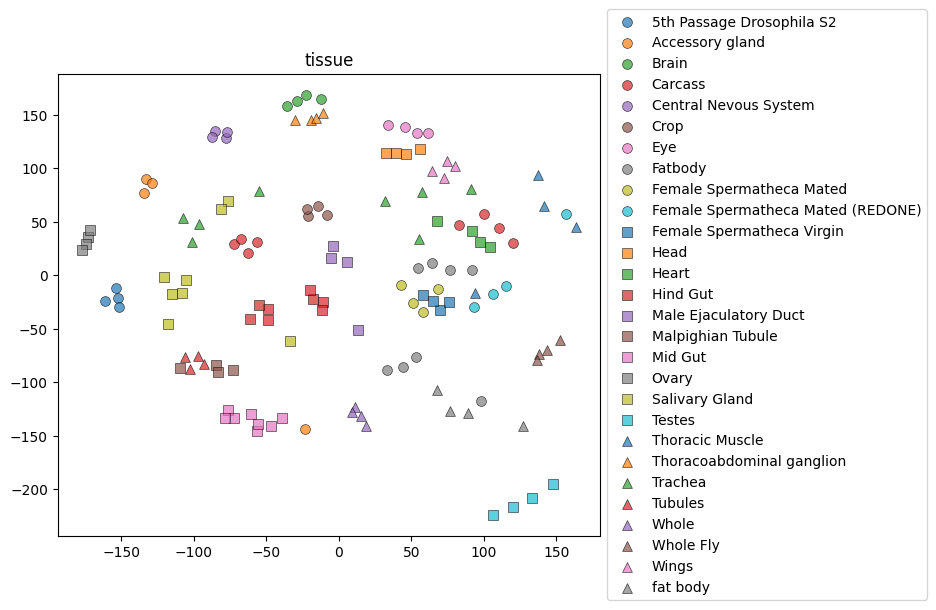

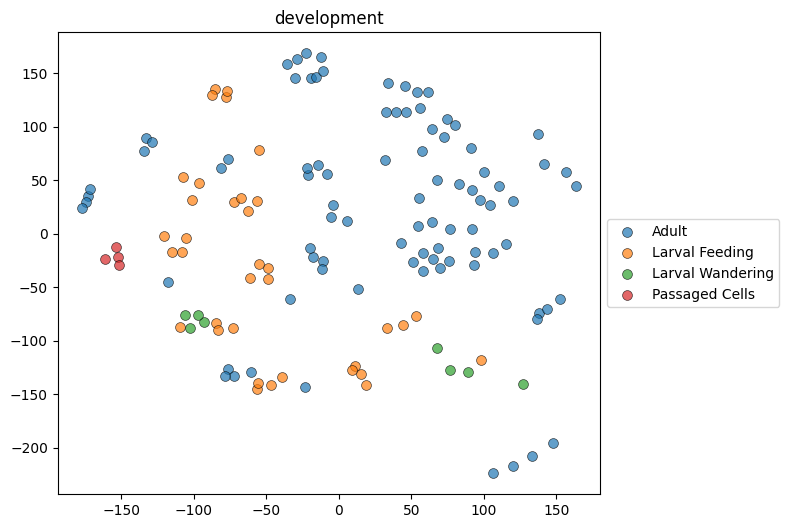

In [44]:
# YOUR CODE HERE
### BEGIN SOLUTION
reducer = MDS(n_components=2)
result = reducer.fit_transform(log_expression.values.T)
result_df = pd.DataFrame(result, index=input_df.index.to_list())
plot_two_dimensions(result_df, meta, 'tissue')
plot_two_dimensions(result_df, meta, 'development')
### END SOLUTION

## Exercise 3: tSNE

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">
<b>Challenge:</b> Try creating a tSNE plot using `TSNE()`, which we imported from `sklearn.manifold`. All scikit-learn models use a consistent syntax, so the syntax is extremely similar to that for `PCA()`.

Examine the documentation either online or just using `help(TSNE)` in the notebook.

`TSNE()` takes several parameters: the most important is `perplexity`. Lower values of perplexity try hard to preserve local structure at the cost of global structure, and vice versa. From the documentation, what is the default value of `perplexity`? What happens if you redo your plot with it set to a much lower or much higher value?
</div>

Helpful resources for learning tSNE:

[StatQuest: t-SNE, Clearly Explained](https://www.youtube.com/watch?v=NEaUSP4YerM)

[t-SNE interactive settings](https://distill.pub/2016/misread-tsne/)

[Datacamp: t-SNE Tutorial](https://www.datacamp.com/community/tutorials/introduction-t-sne)

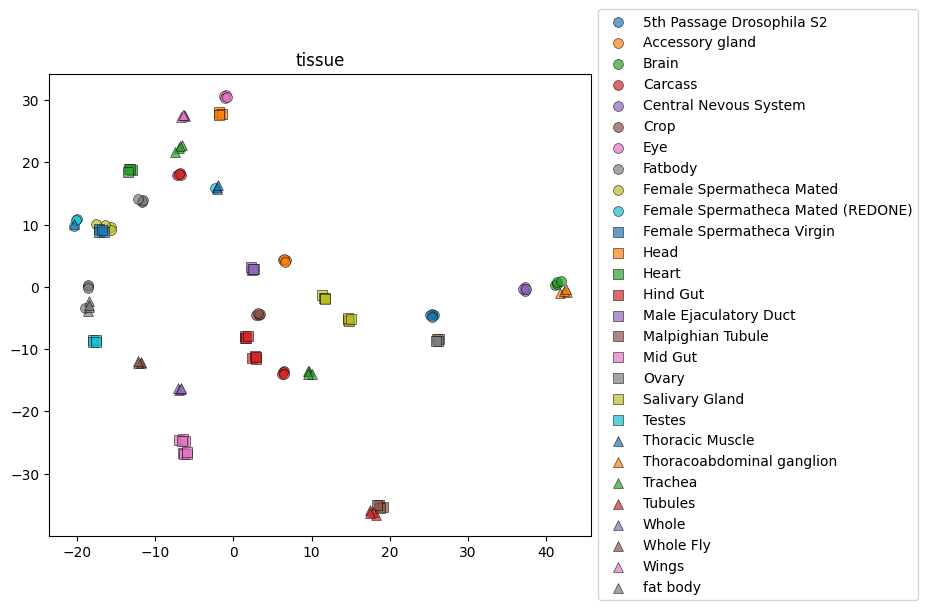

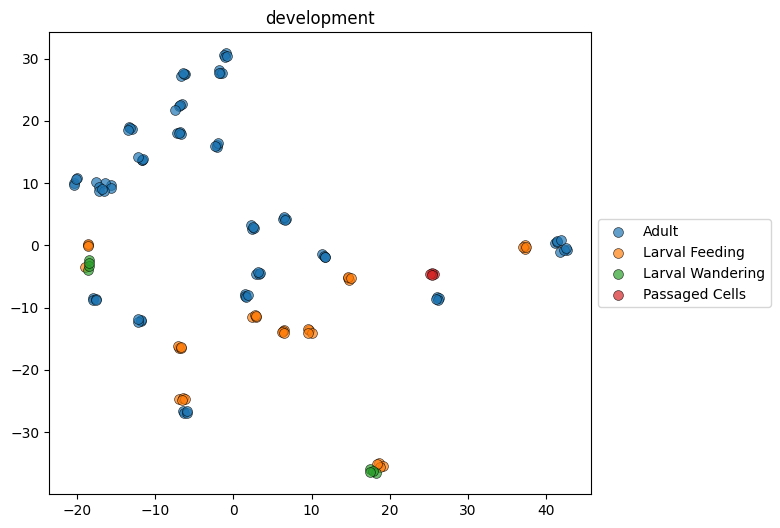

In [22]:
# YOUR CODE HERE
### BEGIN SOLUTION
reducer = TSNE(n_components=2, perplexity=7) # try with perplexity 20, 60
result = reducer.fit_transform(log_expression.values.T)
result_df = pd.DataFrame(result, index=input_df.index.to_list())
plot_two_dimensions(result_df, meta, 'tissue')
plot_two_dimensions(result_df, meta, 'development')
### END SOLUTION

## Exercise 4: UMAP

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">
<b>Challenge:</b> Try creating a UMAP plot using `UMAP()`, which we imported from the `umap` library. `umap` is not part of scikit-learn, but it deliberately uses a similar syntax.

Examine the documentation either online or just using `help(UMAP)` in the notebook.

Look at the available parameters in the documentation. Try varying `n_neighbours` (which has a conceptual similarity to tSNE's `perplexity`) and `min_dist`.
</div>

[UMAP Uniform Manifold Approximation and Projection for Dimension Reduction](https://www.youtube.com/watch?v=nq6iPZVUxZU) video.

/Users/unlock/Projects/Tutor/Github/COMP90014_2025/venv/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


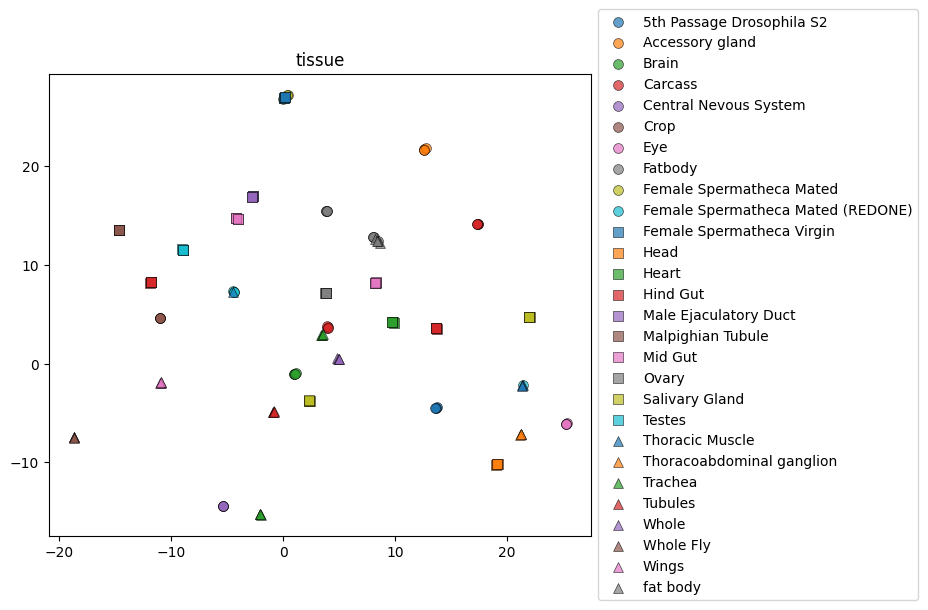

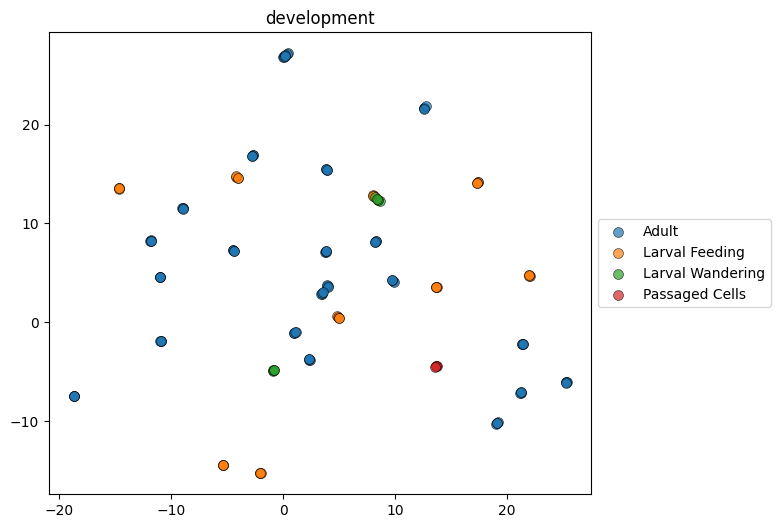

In [33]:
# YOUR CODE HERE
### BEGIN SOLUTION
reducer = umap.UMAP(n_components=2, n_neighbors=4)  # try with different n_neighbors eg 4, 10
result = reducer.fit_transform(log_expression.values.T)
result_df = pd.DataFrame(result, index=input_df.index.to_list())
plot_two_dimensions(result_df, meta, 'tissue')
plot_two_dimensions(result_df, meta, 'development')
### END SOLUTION

## Extension: Linear Discriminant Analysis (LDA)

While PCA and LDA are both linear dimensionality reduction techniques, they have a key difference. 
- PCA aims to maximise total data variance in low-dimensional space. 
- LDA aims to maximise class separation in low-dimensional space. 

In this manner, LDA is a supervised approach and therefore requires class labels. 

<img src='./media/lda_pca.png' width=500>


<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">
<b>Challenge:</b> Try creating LDA plots using `LinearDiscriminantAnalysis()`, which we imported from `sklearn.discriminant_analysis`.

Perform LDA twice, first using <small>`'development'`</small> as sample labels, then <small>`'tissue'`</small> as sample labels. 

You will need to use the <small>`meta`</small> dataframe to associate samples to labels. 

For help, examine the documentation [online](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) or using `help(LinearDiscriminantAnalysis)` in the notebook.

</div>


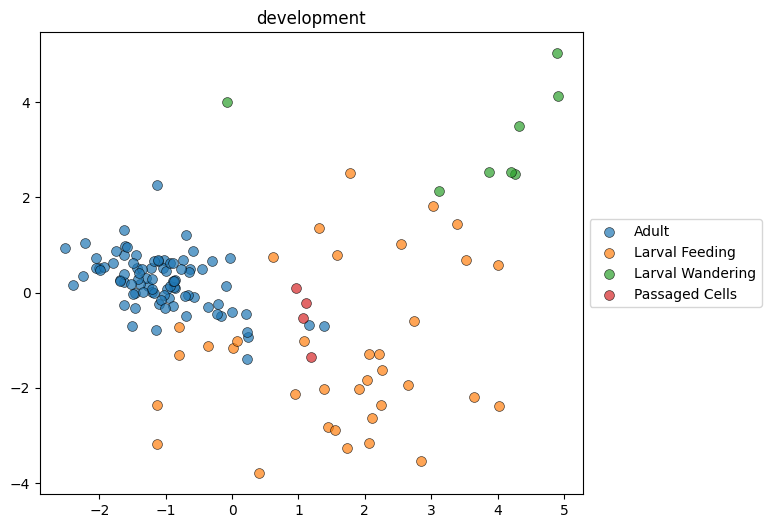

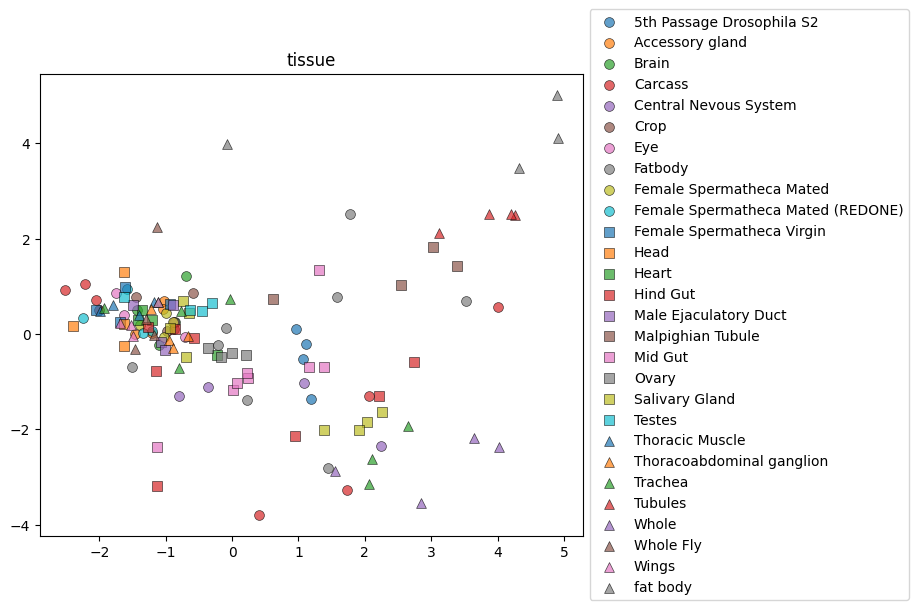

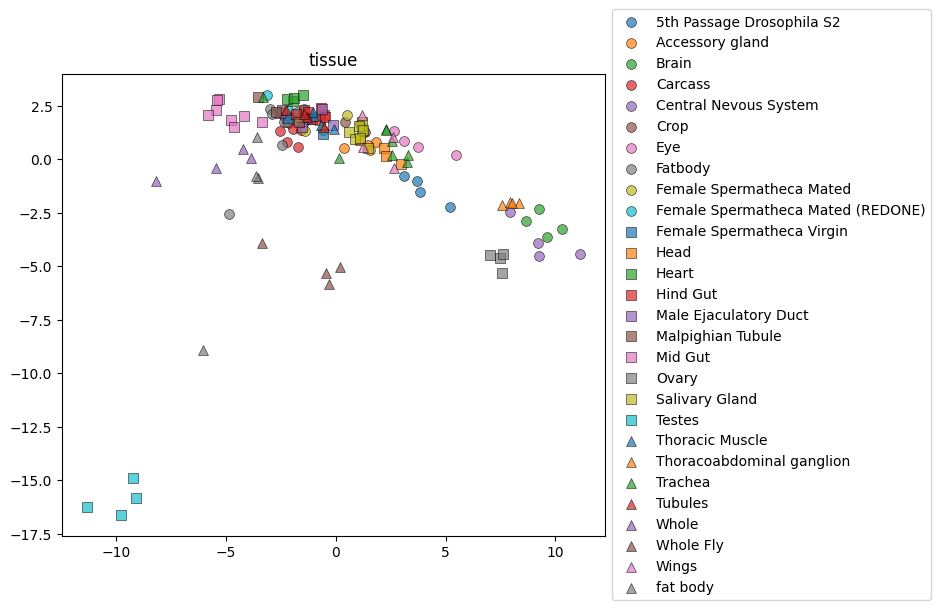

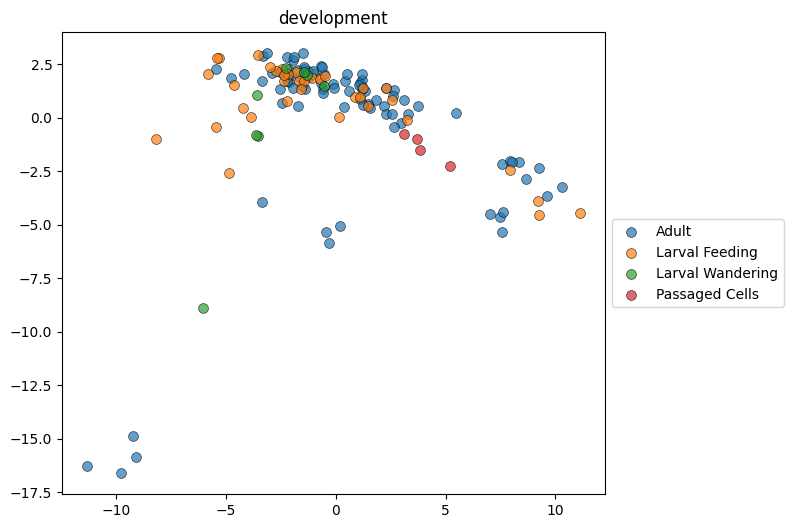

In [37]:
# YOUR CODE HERE
### BEGIN SOLUTION
# LDA with development labels
reducer = LinearDiscriminantAnalysis(n_components=2)
result = reducer.fit_transform(log_expression.T, meta['development'])
result_df = pd.DataFrame(result, index=input_df.index.to_list())
plot_two_dimensions(result_df, meta, 'development')
plot_two_dimensions(result_df, meta, 'tissue')

# LDA with tissue labels
reducer = LinearDiscriminantAnalysis(n_components=2)
result = reducer.fit_transform(log_expression.T, meta['tissue'])
result_df = pd.DataFrame(result, index=input_df.index.to_list())
plot_two_dimensions(result_df, meta, 'tissue')
plot_two_dimensions(result_df, meta, 'development')
### END SOLUTION